# Temat: Predykcja aktywności fizycznej z wykorzystaniem uczenia maszynowego
---
Celem projektu jest opracowanie modelu predykcyjnego, który będzie w stanie dokładnie prognozować
dzienną liczbę kroków użytkownika. Kluczowym aspektem jest identyfikacja najbardziej efektywnej metody
opartej na analizie szeregów czasowych.

Wybór optymalnego rozwiązania zostanie dokonany na podstawie dokładności i niezawodności prognoz,
które zostaną zweryfikowane za pomocą wskaźników jakości, takich jak RMSE, MAE oraz R2.


In [1]:
import warnings
import logging

warnings.filterwarnings('ignore', module='statsmodels')
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
warnings.filterwarnings('ignore')

In [2]:
import xml.etree.ElementTree as ET
import requests
import time
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
import optuna
import lib.functions as functions

pio.templates.default = "plotly_dark"
api_key = ''

# Zebranie danych 
___
Dane zostały pobrane z aplikacji *Health* i pochodzą z czujników telefonu komórkowego, które rejestrowały informacje w okresie od 9 grudnia 2017 do 31 grudnia 2024. Dodatkowo, zestaw danych został wzbogacony o historyczne dane pogodowe zebrane za pomocą API *weather.visualcrossing.com*, dostosowane do lokalizacji Warszawy.

Zawartość danych obejmuje daty pomiarów, poziom aktywności fizycznej, warunki pogodowe oraz dodatkowe zmienne kalendarzowe.

In [3]:
# file_path = 'data/apple_health_export_data/export.xml'    
# tree = ET.parse(file_path)
# root = tree.getroot()

# records = []
# for record in root.findall('Record'):
#     entry = {
#         "sourceName": record.attrib.get("sourceName"),
#         "type": record.attrib.get("type"),
#         "creationDate": record.attrib.get("creationDate"),
#         "startDate": record.attrib.get("startDate"),
#         "endDate": record.attrib.get("endDate"),
#         "value": record.attrib.get("value"),
#         "unit": record.attrib.get("unit"),
#     }
#     records.append(entry)

# health_data = pd.DataFrame(records)
# health_data.to_csv('data/health_data.csv', index=False)

In [4]:
health_data = pd.read_csv('data/health_data.csv', low_memory=False)
health_data.head(5)

,sourceName,type,creationDate,startDate,endDate,value,unit
0,iPhone,HKQuantityTypeIdentifierHeight,2020-02-01 13:16:57 +0100,2020-02-01 13:16:57 +0100,2020-02-01 13:16:57 +0100,168,cm
1,iPhone,HKQuantityTypeIdentifierBodyMass,2020-02-01 13:16:57 +0100,2020-02-01 13:16:57 +0100,2020-02-01 13:16:57 +0100,55,kg
2,Health,HKQuantityTypeIdentifierBodyMass,2024-06-08 09:13:17 +0100,2024-06-08 09:13:00 +0100,2024-06-08 09:13:00 +0100,50,kg
3,Apple Watch (Zuzanna),HKQuantityTypeIdentifierHeartRate,2020-02-01 13:20:25 +0100,2020-02-01 13:17:59 +0100,2020-02-01 13:17:59 +0100,69,count/min
4,Apple Watch (Zuzanna),HKQuantityTypeIdentifierHeartRate,2020-02-01 13:29:35 +0100,2020-02-01 13:29:21 +0100,2020-02-01 13:29:21 +0100,68,count/min


In [5]:
health_data.groupby('type').size().sort_values(ascending=False)

type
HKQuantityTypeIdentifierActiveEnergyBurned                82235
HKQuantityTypeIdentifierDistanceWalkingRunning            65537
HKQuantityTypeIdentifierStepCount                         55403
HKQuantityTypeIdentifierBasalEnergyBurned                 42949
HKQuantityTypeIdentifierHeartRate                         31951
HKQuantityTypeIdentifierHeadphoneAudioExposure            29356
HKQuantityTypeIdentifierWalkingStepLength                  8889
HKQuantityTypeIdentifierWalkingSpeed                       8889
HKQuantityTypeIdentifierFlightsClimbed                     8494
HKQuantityTypeIdentifierWalkingDoubleSupportPercentage     8014
HKQuantityTypeIdentifierAppleStandTime                     6290
HKQuantityTypeIdentifierAppleExerciseTime                  5873
HKQuantityTypeIdentifierWalkingAsymmetryPercentage         4826
HKQuantityTypeIdentifierBodyTemperature                    3868
HKCategoryTypeIdentifierSleepAnalysis                      3754
HKCategoryTypeIdentifierAppleStandH


---

In [6]:
# url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Warsaw,PL/2017-12-09/2024-12-31?unitGroup=metric&key={api_key}&include=days'

# response = requests.get(url)

# if response.status_code == 200:
#     data = response.json()
#     weather_data = pd.DataFrame(data['days'])
#     weather_data.to_csv('data/weather_data.csv', index=False)
# else:
#     print(f"Error: {response.status_code}, {response.text}")

In [7]:
weather_data = pd.read_csv('data/weather_data.csv')
weather_data.head(5)

,datetime,datetimeEpoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,sunriseEpoch,sunset,sunsetEpoch,moonphase,conditions,description,icon,stations,source,tzoffset
0,2017-12-09,1512774000,2.2,-1.0,0.7,0.5,-2.6,-1.3,-2.1,81.8,...,1512801186,15:23:24,1512829404,0.70,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['12376099999', 'EPWA', '12105699999', '123750...",obs,NaN
1,2017-12-10,1512860400,2.7,-0.1,0.9,-0.3,-5.3,-3.0,-2.5,78.0,...,1512887652,15:23:14,1512915794,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['12376099999', 'EPWA', '12105699999', '123750...",obs,NaN
2,2017-12-11,1512946800,6.0,-1.0,3.5,3.4,-6.6,-0.3,-0.2,77.2,...,1512974116,15:23:06,1513002186,0.77,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with rain or ...,rain,"['12376099999', 'EPWA', '12105699999', '123750...",obs,NaN
3,2017-12-12,1513033200,10.9,4.8,7.3,10.9,1.3,4.6,2.0,69.6,...,1513060577,15:23:02,1513088582,0.80,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['12376099999', 'EPWA', '12105699999', '123750...",obs,NaN
4,2017-12-13,1513119600,4.7,-1.8,1.5,1.3,-6.7,-1.7,-2.9,73.0,...,1513147034,15:23:02,1513174982,0.84,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['12376099999', 'EPWA', '12105699999', '123750...",obs,NaN


In [8]:
weather_data.columns

Index(['datetime', 'datetimeEpoch', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'pressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'sunrise', 'sunriseEpoch', 'sunset', 'sunsetEpoch', 'moonphase',
       'conditions', 'description', 'icon', 'stations', 'source', 'tzoffset'],
      dtype='object')

# Przygotowanie danych

### Dane dotyczące aktywności
---

In [9]:
health_data = pd.read_csv('data/health_data.csv', low_memory=False)

In [10]:
steps = health_data[(health_data['sourceName'].isin(['iPhone', 'iPhone (Zuzanna)'])) & (health_data['type'] == 'HKQuantityTypeIdentifierStepCount')][['creationDate', 'value']].reset_index(drop=True)
steps['creationDate'] = pd.to_datetime(steps['creationDate']).dt.normalize().dt.tz_localize(None)
steps['value'] = steps['value'].astype(int)  
steps = steps.rename(columns={'creationDate': 'date'})
steps = steps.groupby('date').sum().reset_index()
date_range = pd.date_range(start="2017-12-09", end="2024-12-31", freq='D')
dates_df = pd.DataFrame(date_range, columns=['date'])
steps = pd.merge(dates_df, steps, on='date', how='left')
steps.head()

,date,value
0,2017-12-09,617.0
1,2017-12-10,1325.0
2,2017-12-11,2559.0
3,2017-12-12,7467.0
4,2017-12-13,4866.0


In [11]:
functions.check_df(df=steps)

##################### SHAPE #####################
(2580, 2)
##################### TYPES #####################
date     datetime64[ns]
value           float64
dtype: object
##################### HEAD #####################
        date   value
0 2017-12-09   617.0
1 2017-12-10  1325.0
2 2017-12-11  2559.0
3 2017-12-12  7467.0
4 2017-12-13  4866.0
##################### TAIL #####################
           date  value
2575 2024-12-27   73.0
2576 2024-12-28  230.0
2577 2024-12-29   41.0
2578 2024-12-30  169.0
2579 2024-12-31  749.0
##################### N/A #####################
date      0
value    54
dtype: int64


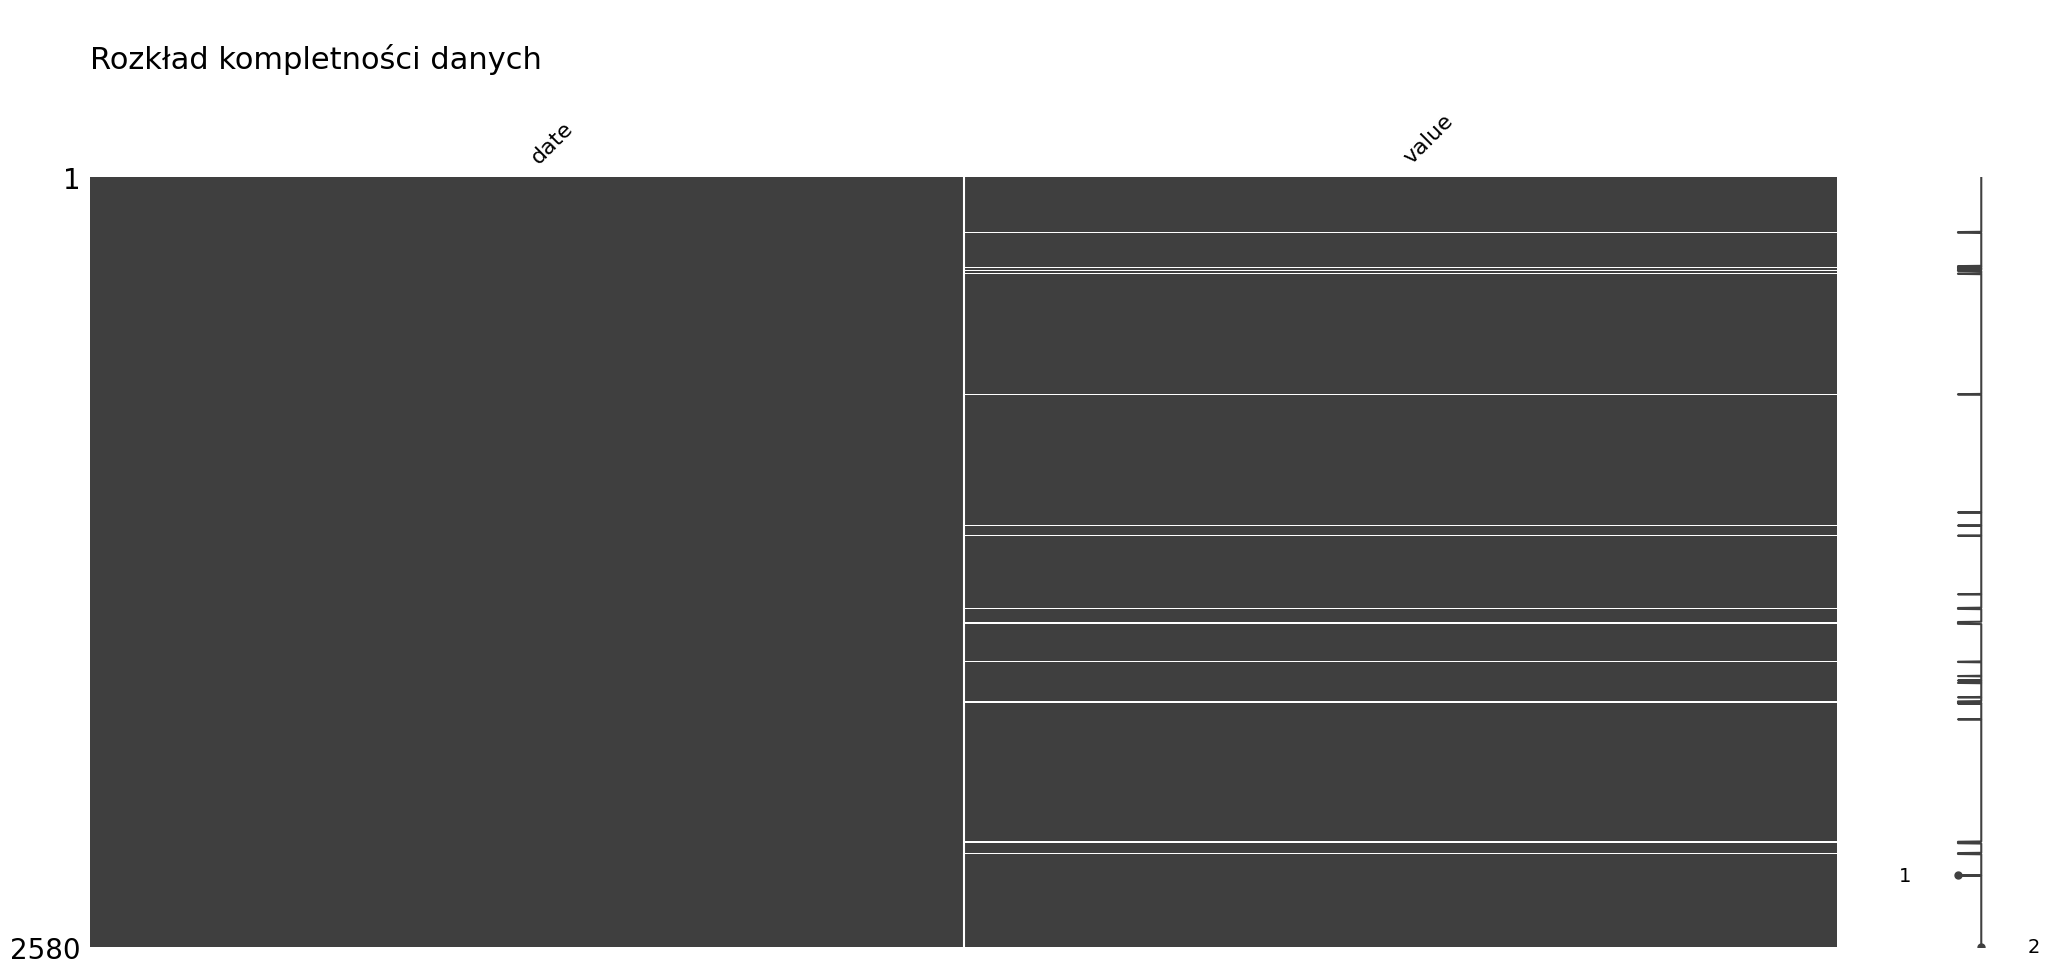

Daty, w których występują brakujące wartości:
184    2018-06-11
185    2018-06-12
186    2018-06-13
298    2018-10-03
302    2018-10-07
303    2018-10-08
307    2018-10-12
311    2018-10-16
312    2018-10-17
313    2018-10-18
314    2018-10-19
323    2018-10-28
324    2018-10-29
727    2019-12-06
728    2019-12-07
1123   2021-01-05
1167   2021-02-18
1201   2021-03-24
1397   2021-10-06
1443   2021-11-21
1444   2021-11-22
1445   2021-11-23
1446   2021-11-24
1490   2022-01-07
1491   2022-01-08
1492   2022-01-09
1493   2022-01-10
1494   2022-01-11
1495   2022-01-12
1496   2022-01-13
1623   2022-05-20
1624   2022-05-21
1671   2022-07-07
1686   2022-07-22
1694   2022-07-30
1742   2022-09-16
1756   2022-09-30
1757   2022-10-01
1758   2022-10-02
1759   2022-10-03
1760   2022-10-04
1763   2022-10-07
1816   2022-11-29
2226   2024-01-13
2227   2024-01-14
2228   2024-01-15
2229   2024-01-16
2230   2024-01-17
2231   2024-01-18
2264   2024-02-20
2265   2024-02-21
2266   2024-02-22
2267   2024-02-23


In [12]:
msno.matrix(steps)
plt.title('\nRozkład kompletności danych\n', fontsize=22, loc='left')
plt.show()

print("Daty, w których występują brakujące wartości:")
missing_dates = steps[steps['value'].isna()]['date']
print(missing_dates)

Brakujące dane dotyczące liczby kroków pojawiają się w przypadkowych miejscach, bez wyraźnego wzorca.

In [13]:
functions.plot_column_distribution(steps, 'value', 'Rozkład liczby kroków', labels={'sum of count':'', 'value':''})

Statystyki dla kolumny 'value':
count     2526.000000
mean      3550.988915
std       4313.730680
min          1.000000
25%        413.000000
50%       1840.500000
75%       5358.250000
max      43670.000000
Name: value, dtype: float64


Większość wartości jest stosunkowo niska, a rozkład danych jest silnie asymetryczny. Występują sporadyczne, bardzo wysokie wartości odstające. Średnia jest zawyżona przez skrajne przypadki.

In [14]:
functions.outliers_summary(steps, 'value')

Łączna liczba wartości odstających: 100

Statystyki dla wartości odstających:
count      100.000000
mean     17212.520000
std       5007.313109
min      12787.000000
25%      13734.250000
50%      15824.000000
75%      18562.250000
max      43670.000000
Name: value, dtype: float64


Wartości odstające stanowią niewielką część danych, ale ich średnia znacznie przekracza ogólną średnią, co wskazuje na sporadyczne dni o wyjątkowo wysokiej aktywności.

In [15]:
steps = functions.replace_outliers_and_nans(steps, 'value')
functions.plot_column_distribution(steps, 'value', 'Rozkład liczby kroków po interpolacji', labels={'sum of count':'', 'value':''})

Statystyki dla kolumny 'value':
count     2580.000000
mean      3059.534496
std       3205.394559
min          1.000000
25%        409.000000
50%       1795.500000
75%       4937.750000
max      12748.000000
Name: value, dtype: float64


Po interpolacji dane są bardziej spójne, a ich rozkład zachowuje ogólną strukturę. Zmniejszono wpływ wartości odstających i nieciągłości, poprawiając ciągłość danych bez znaczących zmian w kształcie rozkładu.

### Dane pogodowe
---

Z początkowego zbioru danych pogodowych dokonano selekcji parametrów, które najbardziej prawdopodobnie wpływają na aktywność fizyczną. Wybrane zmienne to temperatura powietrza (temp), wilgotność (humidity), opady deszczu (precipcover), prędkość wiatru (windspeed), stopień zachmurzenia (cloudcover), widoczność (visibility) oraz promieniowanie słoneczne (solarradiation). 

In [16]:
weather_data = pd.read_csv('data/weather_data.csv')

In [17]:
weather = weather_data[['datetime', 'temp',  'humidity', 'precipcover', 'windspeed', 'cloudcover','visibility', 'solarradiation']].rename(columns={'datetime': 'date'})
weather.date = pd.to_datetime(weather.date)
weather

,date,temp,humidity,precipcover,windspeed,cloudcover,visibility,solarradiation
0,2017-12-09,0.7,81.8,0.00,14.5,71.9,12.3,28.6
1,2017-12-10,0.9,78.0,0.00,20.3,77.7,14.1,25.4
2,2017-12-11,3.5,77.2,8.33,21.1,81.6,17.0,16.9
3,2017-12-12,7.3,69.6,0.00,26.5,78.7,17.7,21.1
4,2017-12-13,1.5,73.0,0.00,20.4,59.3,15.4,24.4
...,...,...,...,...,...,...,...,...
2575,2024-12-27,1.1,97.8,0.00,8.4,99.1,3.1,11.8
2576,2024-12-28,0.8,97.9,0.00,7.4,100.0,4.2,5.7
2577,2024-12-29,2.2,96.4,0.00,18.5,86.4,3.8,16.0
2578,2024-12-30,0.9,96.8,0.00,23.4,100.0,5.5,3.2


In [18]:
functions.check_df(weather)

##################### SHAPE #####################
(2580, 8)
##################### TYPES #####################
date              datetime64[ns]
temp                     float64
humidity                 float64
precipcover              float64
windspeed                float64
cloudcover               float64
visibility               float64
solarradiation           float64
dtype: object
##################### HEAD #####################
        date  temp  humidity  precipcover  windspeed  cloudcover  visibility  \
0 2017-12-09   0.7      81.8         0.00       14.5        71.9        12.3   
1 2017-12-10   0.9      78.0         0.00       20.3        77.7        14.1   
2 2017-12-11   3.5      77.2         8.33       21.1        81.6        17.0   
3 2017-12-12   7.3      69.6         0.00       26.5        78.7        17.7   
4 2017-12-13   1.5      73.0         0.00       20.4        59.3        15.4   

   solarradiation  
0            28.6  
1            25.4  
2            16.9  
3 

In [19]:
functions.plot_boxplot_summary(weather, 'Rozkłady poszczególnych zmiennych pogodowych', labels={'Value':'', 'Variable':''})

Statystyki dla zmiennych numerycznych:
          humidity  precipcover    windspeed   cloudcover   visibility  \
count  2580.000000  2580.000000  2580.000000  2580.000000  2580.000000   
mean     73.348256     5.717504    19.880078    61.192674    14.324767   
std      14.553708    11.276712     6.731558    23.365275     4.164520   
min      29.000000     0.000000     4.600000     0.000000     1.200000   
25%      63.300000     0.000000    15.100000    46.000000    11.700000   
50%      74.900000     0.000000    19.000000    63.750000    15.600000   
75%      85.125000     4.170000    23.900000    79.800000    17.800000   
max      99.500000    91.670000    52.000000   100.000000    21.900000   

       solarradiation  
count     2580.000000  
mean       117.476822  
std         89.531992  
min          3.200000  
25%         31.775000  
50%         98.800000  
75%        191.325000  
max        342.900000  


Większość zmiennych cechuje niewielkie rozproszenie, jednak promieniowanie słoneczne i opady deszczu wykazują silną asymetrię oraz liczne wartości odstające.

# Analiza danych

In [20]:
steps = functions.create_date_features(steps, 'date')
df = pd.merge(steps, weather, how='left', on='date')
df.head()

,date,value,month,year,day_of_week,is_wknd,temp,humidity,precipcover,windspeed,cloudcover,visibility,solarradiation
0,2017-12-09,617.0,12,2017,6,1,0.7,81.8,0.00,14.5,71.9,12.3,28.6
1,2017-12-10,1325.0,12,2017,7,1,0.9,78.0,0.00,20.3,77.7,14.1,25.4
2,2017-12-11,2559.0,12,2017,1,0,3.5,77.2,8.33,21.1,81.6,17.0,16.9
3,2017-12-12,7467.0,12,2017,2,0,7.3,69.6,0.00,26.5,78.7,17.7,21.1
4,2017-12-13,4866.0,12,2017,3,0,1.5,73.0,0.00,20.4,59.3,15.4,24.4


## Analiza szeregu czasowego
---

In [21]:
fig = px.line(df, y='value', x='date', title="Aktywność fizyczna w latach 2018-2024", labels={'value': 'Ilość kroków', 'date':''})
fig.show()

Widać dużą zmienność oraz liczne skoki wartości w różnych okresach. Szczególnie widoczny jest spadek aktywności w okolicach 2020 roku. Po 2021 roku pojawia się większa nieregularność, choć wartości wciąż wykazują znaczną zmienność w określonych momentach.

In [22]:
result = adfuller(df.value)
print(f"Test ADF statystyka = {result[0]:.4f}, p-value = {result[1]:.4f}")
print("Wynik testu ADF sugeruje, że szereg czasowy jest stacjonarny." if result[1] < 0.05 else "Wynik testu ADF sugeruje, że szereg czasowy nie jest stacjonarny.")

Test ADF statystyka = -5.2570, p-value = 0.0000
Wynik testu ADF sugeruje, że szereg czasowy jest stacjonarny.


In [23]:
functions.plot_seasonal_decompose(df, 'value', title='Dekompozycja')

Ogólny trend spadkowy do 2020 roku, a następnie stopniowy wzrost aktywności. Sezonowość pozostaje stabilna przez cały okres, wskazując na cykliczne wzorce w danych. Reszty wykazują losowe wahania bez wyraźnych anomalii.

In [24]:
functions.plot_autocorrelation(df.value, title='Autokorelacja (ACF)', alpha=0.01, show_pacf=False)
functions.plot_autocorrelation(df.value, title='Cząstkowa autokorelacja (PACF)', alpha=0.01, show_pacf=True)

Silna korelacja dla lagów 1-2 oznacza, że aktywność jednego dnia mocno zależy od poprzedniego. Natomiast podwyższone wartości dla 7, 14 i 21 wskazują na powtarzający się tygodniowy schemat aktywności.

In [25]:
window_sizes = np.arange(1, 51)
diff_values = []

for window in window_sizes:
    diff_series = df['value'].diff(periods=window).dropna()
    avg_diff = np.mean(np.abs(diff_series))
    diff_values.append(avg_diff)

df_diff = pd.DataFrame({
    'Window Size': window_sizes,
    'Average Diff': diff_values
})

functions.plot_line(df_diff, 'Window Size', 'Average Diff', 'Średni wpływ liczby poprzednich obserwacji na zmiany w szeregu czasowym', labels={'Window Size': 'Długość okna', 'Average Diff': 'Średnia różnica diff'})

Silne zmiany dla krótkich okien sugerują, że krótkoterminowe wahania mają duży wpływ na szereg czasowy. Wartości dla 7, 14 i 21 dni wskazują na obecność cykli sezonowych, z wyraźnym tygodniowym i wielotygodniowym rytmem.

In [26]:
correlations = functions.calculate_rolling_means_and_correlation_with_value(df, max_window=60)
fig = px.bar(correlations, x=correlations.index, y=correlations.values, labels={'index': 'Liczba uśrednionych dni', 'y': 'Korelacja z aktywnością'}, title='Korelacja średnich kroczących z aktywnością w zależności od liczby dni uśredniania')
fig.show()

Korelacja jest najwyższa dla krótkich średnich kroczących i stopniowo maleje wraz ze wzrostem okna średniej kroczącej, wskaując na dominację trendu krótkoterminowego nad długoterminowym.

## Analiza zmiannych dodatkowych
---

In [27]:
functions.plot_correlation_clustermap(df, 'Mapa korelacji')

Korelacje między liczbą kroków a innymi zmiennymi są ogólnie słabe. Zmienne pogodowe oraz czasowe nie wykazują istotnych powiązań, a ich wpływ na aktywność jest znikomy.

In [28]:
functions.plot_nonlinear_relationship(df, target='value', title='Mapa zależności nieliniowych')

Analiza nieliniowych zależności nie ujawnia silniejszych powiązań niż korelacje liniowe. 

### Zmienne kalendarzowe
---

In [29]:
functions.plot_boxplot(df, x='year', y='value', title='Aktywność w zależności od roku', labels={'value': 'Ilość kroków', 'year': 'Rok'})
df.groupby('year')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2017,23.0,3670.195652,3302.855441,34.0,914.00,2959.0,5564.25,12680.0
2018,365.0,4583.028767,3265.224348,5.0,2139.00,4339.0,6424.00,12151.0
2019,365.0,4606.960274,3309.358526,8.0,1710.00,4363.0,6881.00,12662.0
2020,366.0,1747.202186,2237.975563,11.0,214.50,966.0,2340.25,12748.0
2021,365.0,2287.123288,2759.912377,1.0,341.00,1176.0,3080.00,12554.0
2022,365.0,2999.739726,3225.671614,2.0,408.00,1721.0,4749.00,12702.0
2023,365.0,2938.387671,3293.902046,21.0,395.00,1237.0,4883.00,12628.0
2024,366.0,2221.710383,2966.409089,3.0,168.25,761.5,3255.75,12516.0


Aktywność osiągnęła najwyższy poziom w latach 2017-2019. W 2020 roku nastąpił gwałtowny spadek, a od 2021 roku obserwuje się stopniowy wzrost, przy czym zmienność nadal pozostaje wysoka.

In [30]:
steps_by_month = df.groupby('month')['value'].mean().reset_index()
functions.plot_line(steps_by_month, 'month', 'value', 'Średnia aktywność w poszczególnych miesiącach', labels={'value': 'Ilość kroków', 'month': 'Miesiąc'})

Aktywność wykazuje wyraźną sezonowość – najniższe wartości występują w lutym, kwietniu i listopadzie, podczas gdy najwyższe w październiku i grudniu.

In [31]:
df_copy = df.copy()
df_copy['season'] = df_copy['month'].apply(lambda x: 'warm' if 4 <= x <= 9 else 'cold')
functions.plot_boxplot(df_copy, x='season', y='value', title='Rozkład aktywności w zależności od sezonu', labels={'value': 'Ilość kroków', 'season': 'Sezon'})
functions.group_normality_and_comparison(df_copy, target='value', group_col='season', alternative='greater')

Test Shapiro-Wilka dla grupy cold: p = 0.0000
Test Shapiro-Wilka dla grupy warm: p = 0.0000
Test Manna-Whitneya: statystyka = 867864.0000, p-wartość = 0.0290
Różnice między grupami są statystycznie istotne.


Liczba kroków w chłodnych miesiącach jest statystycznie wyższa niż w ciepłych miesiącach.

In [32]:
steps_by_week = df.groupby('day_of_week')['value'].mean().reset_index()
functions.plot_line(steps_by_week, 'day_of_week', 'value', 'Średnia aktywność w poszczególnych dniach tygodnia', labels={'value': 'Ilość kroków', 'day_of_week': 'Dzień tygodnia'})

Aktywność jest najwyższa w czwartki i piątki, a najniższa w weekendy, co sugeruje, że dni robocze sprzyjają większej liczbie kroków, podczas gdy sobota i niedziela charakteryzują się mniejszą mobilnością.

In [33]:
functions.plot_boxplot(df, x='is_wknd', y='value', title='Aktywność w zależności od dnia tygodnia', labels={'value': 'Ilość kroków',  'is_wknd': 'Typ dnia (0 - dni robocze, 1 - weekend)'})
functions.group_normality_and_comparison(df, target='value', group_col='is_wknd', alternative='less')

Test Shapiro-Wilka dla grupy 1: p = 0.0000
Test Shapiro-Wilka dla grupy 0: p = 0.0000
Test Manna-Whitneya: statystyka = 767041.5000, p-wartość = 0.0051
Różnice między grupami są statystycznie istotne.


Liczba kroków w weekend jest statystycznie niższa niż w dni robocze.

### Zmienne pogodowe
---

In [34]:
monthly_activity = df.groupby('month').agg({'temp': 'mean', 'humidity': 'mean', 'precipcover': 'median', 'windspeed': 'mean', 'cloudcover': 'median', 'visibility': 'mean', 'solarradiation': 'mean', 'value': 'median'}).reset_index()
scaler = StandardScaler()
columns_to_normalize = ['temp', 'humidity', 'precipcover', 'windspeed', 'cloudcover', 'visibility', 'solarradiation', 'value']
monthly_activity_normalized = monthly_activity.copy()
monthly_activity_normalized[columns_to_normalize] = scaler.fit_transform(monthly_activity[columns_to_normalize])
functions.plot_line_subplots(monthly_activity_normalized, time_col='month', value_col='value', variables=['temp', 'humidity', 'precipcover', 'windspeed', 'cloudcover', 'visibility', 'solarradiation'], title='Znormalizowane wartości zmiennych pogodowych i liczby kroków w poszczególnych miesiącach')

Zmienność liczby kroków w poszczególnych miesiącach wykazuje słabe korelacje z większością zmiennych pogodowych, z nieco wyraźniejszymi powiązaniami dla temperatury, pokrywy opadów i widoczności. Wpływ warunków atmosferycznych na aktywność jest niewielki i nie wskazuje na jednoznaczne zależności.

In [35]:
bins_temp = [-20, 0, 10, 20, 30] 
bin_labels_temp = ['<0°C', '0-10°C', '10-20°C', '>20°C']
functions.plot_scatter_binned(df, 'value', 'temp', bins=bins_temp, bin_labels=bin_labels_temp)

bins_humidity = [0, 30, 60, 90] 
bin_labels_humidity = ['0-30%', '30-60%', '60-90%']
functions.plot_scatter_binned(df, 'value','humidity', bins=bins_humidity, bin_labels=bin_labels_humidity)

bins_precipcover = [0, 25, 50, 75, 100] 
bin_labels_precipcover = ['0-25%', '25-50%', '50-75%', '75-100%']
functions.plot_scatter_binned(df, 'value','precipcover', bins=bins_precipcover, bin_labels=bin_labels_precipcover)

bins_windspeed = [0, 5, 15, 25, 35] 
bin_labels_windspeed = ['0-5 km/h', '5-15 km/h', '15-25 km/h', '25-35 km/h']
functions.plot_scatter_binned(df, 'value', 'windspeed', bins=bins_windspeed, bin_labels=bin_labels_windspeed)

bins_cloudcover = [0, 20, 40, 60, 80, 100] 
bin_labels_cloudcover = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
functions.plot_scatter_binned(df, 'value', 'cloudcover', bins=bins_cloudcover, bin_labels=bin_labels_cloudcover)

bins_visibility = [0, 5, 10, 20, 50]
bin_labels_visibility = ['0-5 km', '5-10 km', '10-20 km', '20-50 km']
functions.plot_scatter_binned(df, 'value', 'visibility', bins=bins_visibility, bin_labels=bin_labels_visibility)

bins_solarradiation = [0, 50, 100, 150, 200, 250] 
bin_labels_solarradiation = ['0-50 W/m²', '50-100 W/m²', '100-150 W/m²', '150-200 W/m²', '200-250 W/m²']
functions.plot_scatter_binned(df, 'value', 'solarradiation', bins=bins_solarradiation, bin_labels=bin_labels_solarradiation)

Zmienność liczby kroków w zależności od warunków pogodowych wykazuje umiarkowane powiązania. Ekstremalne warunki, takie jak bardzo niska temperatura, silny wiatr czy ograniczona widoczność, mogą wpływać na redukcję aktywności, jednak ogólny wpływ pogody na liczbę kroków pozostaje ograniczony i niejednoznaczny.

In [36]:
df_copy = df.copy()
df_copy['precipitation_status'] = df_copy['precipcover'].apply(lambda x: 'rainy' if x > 0 else 'dry')
functions.plot_boxplot(df_copy, x='precipitation_status', y='value', title='Rzokład aktywności w zależności deszczu', labels={'value': 'Ilość kroków', 'precipitation_status': ''})
functions.group_normality_and_comparison(df_copy, target='value', group_col='precipitation_status', alternative='greater')

Test Shapiro-Wilka dla grupy dry: p = 0.0000
Test Shapiro-Wilka dla grupy rainy: p = 0.0000
Test Manna-Whitneya: statystyka = 876895.5000, p-wartość = 0.0045
Różnice między grupami są statystycznie istotne.


Liczba kroków jest mniejsza w deszczowe dni w porównaniu do słonecznych.

In [37]:
df_copy = df.copy()
df_copy['windspeed_category'] = df_copy['windspeed'].apply(lambda x: 'high' if x > 30 else 'low')
functions.plot_boxplot(df_copy, x='windspeed_category', y='value', title='Rzokład aktywności w zależności od prędkości wiatru', labels={'value': 'Ilość kroków', 'windspeed_category': ''})
functions.group_normality_and_comparison(df_copy, target='value', group_col='windspeed_category', alternative='greater')

Test Shapiro-Wilka dla grupy low: p = 0.0000
Test Shapiro-Wilka dla grupy high: p = 0.0000
Test Manna-Whitneya: statystyka = 261956.0000, p-wartość = 0.0090
Różnice między grupami są statystycznie istotne.


W bardzo wietrzne dni liczba kroków jest istotnie mniejsza.

In [38]:
df_copy = df.copy()
df_copy['cloudcover_category'] = df_copy['cloudcover'].apply(lambda x: 'cloudy' if x >= 60 else 'clear')
functions.plot_boxplot(df_copy, x='cloudcover_category', y='value', title='Rzokład aktywności w zależności od zachmurzenia', labels={'value': 'Ilość kroków', 'cloudcover_category': ''})
functions.group_normality_and_comparison(df_copy, target='value', group_col='cloudcover_category', alternative='less')

Test Shapiro-Wilka dla grupy cloudy: p = 0.0000
Test Shapiro-Wilka dla grupy clear: p = 0.0000
Test Manna-Whitneya: statystyka = 755234.0000, p-wartość = 0.0005
Różnice między grupami są statystycznie istotne.


Liczba kroków w pochmurne dni jest statystycznie niższa niż w niepochmurne.

# Modelowanie

Do predykcji dziennej liczby kroków wykorzystano modele szeregów czasowych Prophet oraz SARIMA.  

Skuteczność modeli oceniono za pomocą miar błędu: RMSE, MAE oraz R², które określają precyzję i niezawodność prognoz. Wszystkie eksperymenty zostały zweryfikowane na zbiorze walidacyjnym.  

Cechy modelu zostały starannie wyselekcjonowane na podstawie testów oraz analizy danych. Przeprowadzono walidację krzyżową, selekcję oraz dostrajanie hiperparametrów, a następnie oceniono modele na zbiorze testowym w celu wyboru optymalnego podejścia do modelowania.

In [39]:
df_copy = df[['date', 'value']].copy()
df_copy.set_index('date', inplace=True)

In [40]:
lag_periods = [1, 2, 7]
rolling_windows = [8, 15, 22, 43]
diff_values = [4, 9, 15, 35]

In [41]:
train, val = functions.prepare_train_test(df_copy, train_start_date='2017-12-09', train_end_date='2022-12-31', test_start_date='2023-01-01', test_end_date='2023-12-31', lag_periods=lag_periods, rolling_windows=rolling_windows, diff_values=diff_values)
functions.plot_data_with_splits(train, val)

In [42]:
exog_features=list(train.drop(['value'], axis=1).columns.values)

### Porównanie modeli SARIMA i Prophet
---

In [43]:
start_time = time.time()
sarima_model = SARIMAX(train['value'], exog=train[exog_features],     enforce_stationarity=False, 
    enforce_invertibility=False)
sarima_fit = sarima_model.fit()
end_time = time.time()
sarima_training_time = end_time - start_time
sarima_pred = sarima_fit.predict(start=val.index[0], end=val.index[-1], exog=val[exog_features])
sarima_pred[sarima_pred < 0] = 0

df_train = pd.DataFrame({'date': train.index, 'value': train['value'], 'label': 'Train'})
df_test = pd.DataFrame({'date': val.index, 'value': val['value'], 'label': 'Test'})
df_model = pd.DataFrame({'date': val.index, 'value': sarima_pred, 'label': 'SARIMA'})
df_plot = pd.concat([df_train, df_test, df_model])
functions.plot_forecasts(df_plot, 'Prognoza modelu - SARIMA')

rmse_sarima = root_mean_squared_error(val['value'], sarima_pred)
mae_sarima = mean_absolute_error(val['value'], sarima_pred)
r2_sarima = r2_score(val['value'], sarima_pred)
sarima_training_time = end_time - start_time


/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [44]:
df_prophet = train[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})
start_time = time.time()
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
for col in exog_features:
    prophet_model.add_regressor(col)
prophet_model.fit(df_prophet)
end_time = time.time()
future = pd.DataFrame(pd.date_range(start=val.index.min(), end=val.index.max(), freq='D'), columns=["ds"])
for col in exog_features:
    future[col] = val[col].values
forecast = prophet_model.predict(future)
forecast[forecast['yhat'] < 0] = 0

df_train = pd.DataFrame({'date': train.index, 'value': train['value'], 'label': 'Train'})
df_test = pd.DataFrame({'date': val.index, 'value': val['value'], 'label': 'Test'})
df_model = pd.DataFrame({'date': val.index, 'value': forecast['yhat'], 'label': 'PROPHET'})
df_plot = pd.concat([df_train, df_test, df_model])
functions.plot_forecasts(df_plot, 'Prognoza modelu - PROPHET')

rmse_prophet = root_mean_squared_error(val['value'], forecast['yhat'])
mae_prophet = mean_absolute_error(val['value'], forecast['yhat'])
r2_prophet = r2_score(val['value'], forecast['yhat'])
prophet_training_time = end_time - start_time

09:32:37 - cmdstanpy - INFO - Chain [1] start processing
09:32:38 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
results = pd.DataFrame({
    "Model": ["SARIMA", "Prophet"],
    "RMSE": [ rmse_sarima, rmse_prophet],
    "MAE": [ mae_sarima, mae_prophet],
    "R²": [ r2_sarima , r2_prophet],
    'Training Time (s)': [sarima_training_time, prophet_training_time]
})
results

,Model,RMSE,MAE,R²,Training Time (s)
0,SARIMA,1171.488541,859.622811,0.873163,12.647226
1,Prophet,1165.296144,855.007557,0.874500,0.227708


In [46]:
forecast_values = {
    "SARIMA": sarima_pred.values, 
    "Prophet": forecast['yhat'].values
}
df_actual = pd.DataFrame({'date': val.index, 'value': val['value'], 'label': 'Actual'})
df_forecast = pd.concat([pd.DataFrame({'date': val.index, 'value': forecast_data, 'label': model}) for model, forecast_data in forecast_values.items()], ignore_index=True)
df_plot = pd.concat([df_actual, df_forecast])
functions.plot_forecasts(df_plot, title='Porównanie prognoz różnych modeli z rzeczywistymi danymi')

SARIMA i Prophet osiągają zbliżone wyniki. Prophet wyróżnia się krótszym czasem trenowania, co może być istotne przy większych zbiorach danych.

In [47]:
cv, _ = functions.prepare_train_test(df_copy, train_start_date='2017-12-09', train_end_date='2024-12-31', test_start_date='2025-01-01', test_end_date='2025-12-31', lag_periods=lag_periods, rolling_windows=rolling_windows, diff_values=diff_values)

tscv = TimeSeriesSplit(n_splits=10) 

mae_sarima_list = []
rmse_sarima_list = []
r2_sarima_list = []

mae_prophet_list = []
rmse_prophet_list = []
r2_prophet_list = []

for fold, (train_index, test_index) in enumerate(tscv.split(cv)):
    train, test = cv.iloc[train_index], cv.iloc[test_index]

    mae_sarima, rmse_sarima, r2_sarima = functions.evaluate_sarima(train, test, exog_features)
    mae_sarima_list.append(mae_sarima)
    rmse_sarima_list.append(rmse_sarima)
    r2_sarima_list.append(r2_sarima)
    
    mae_prophet, rmse_prophet, r2_prophet = functions.evaluate_prophet(train, test, exog_features)
    mae_prophet_list.append(mae_prophet)
    rmse_prophet_list.append(rmse_prophet)
    r2_prophet_list.append(r2_prophet)

results = pd.DataFrame({
    "Model": ["SARIMA", "Prophet"],
    "RMSE": [np.mean(rmse_sarima_list), np.mean(rmse_prophet_list)],
    "MAE": [np.mean(mae_sarima_list), np.mean(mae_prophet_list)],
    "R²": [np.mean(r2_sarima_list), np.mean(r2_prophet_list)]
})
results

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

09:32:38 - cmdstanpy - INFO - Chain [1] start processing
09:32:38 - cmdstanpy - INFO - Chain [1] done processing
/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

09:32:39 - cmdstanpy - INFO - Chain [1] start processing
09:32:39 - cmdstanpy - INFO - Chai

,Model,RMSE,MAE,R²
0,SARIMA,1130.035370,865.818659,0.849631
1,Prophet,1108.470742,867.929331,0.853193


SARIMA uzyskuje lepsze wyniki walidacyjne niż Prophet. Różnice są niewielkie, ale stabilność SARIMA w wielokrotnych podziałach danych sugeruje jej większą odporność na zmienność.

### Selekcja i dostrajanie modelu
---

In [48]:
train, val = functions.prepare_train_test(df_copy, train_start_date='2017-12-09', train_end_date='2022-12-31', test_start_date='2023-01-01', test_end_date='2023-12-31', lag_periods=lag_periods, rolling_windows=rolling_windows, diff_values=diff_values)

df_train = train[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})
df_val = val[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})

def objective(trial):
    p = trial.suggest_int('p', 0, 7)  
    d = trial.suggest_int('d', 0, 2)  
    q = trial.suggest_int('q', 0, 7)  
    P = trial.suggest_int('P', 0, 4)  
    D = trial.suggest_int('D', 0, 1)  
    Q = trial.suggest_int('Q', 0, 4)  
    s = 7  
    try:
        model = SARIMAX(df_train['y'], order=(p, d, q), seasonal_order=(P, D, Q, s), exog=df_train[exog_features], enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(df_val), exog=df_val[exog_features])
        y_true = df_val['y'].values
        mae_value = mean_absolute_error(y_true, forecast)
    except:
        return np.inf 
    return mae_value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)  

print("Najlepsze parametry:", study.best_params)
print("MAE:", study.best_value)
best_params = study.best_params

[I 2025-02-01 09:33:54,557] A new study created in memory with name: no-name-3e066391-fd09-4dfc-a066-b671ef38dfe1
/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

[I 2025-02-01 09:34:21,297] Trial 0 finished with value: 6518.864140211478 and parameters: {'p': 0, 'd': 2, 'q': 1, 'P': 3, 'D': 0, 'Q': 3}. Best is trial 0 with value: 6518.864140211478.
[I 2025-02-01 09:34:31,912] Trial 1 finished with value: 1095.2894925482349 and parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 1}. Best is trial 1 with value: 1095.2894925482349.
/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

[I 2025-02-01 09:35:34,508] Trial 2 finished with value: 240977.39864624562 and parameters: {'p': 6, 'd': 2, 'q': 3, 'P': 4, 'D'

Najlepsze parametry: {'p': 2, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 3}
MAE: 966.2822675369597


In [49]:
train, val = functions.prepare_train_test(df_copy, train_start_date='2017-12-09', train_end_date='2022-12-31', test_start_date='2023-01-01', test_end_date='2023-12-31', lag_periods=lag_periods, rolling_windows=rolling_windows, diff_values=diff_values)

best_p = best_params['p']
best_d = best_params['d']
best_q = best_params['q']
best_P = best_params['P']
best_D = best_params['D']
best_Q = best_params['Q']
best_s = 7  

sarima_model = SARIMAX(train['value'], order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, best_s), exog=train[exog_features], enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

future_exog = val[exog_features]  
forecast = sarima_fit.forecast(steps=len(val), exog=future_exog)
forecast[forecast < 0] = 0  

df_train_plot = pd.DataFrame({'date': train.index, 'value': train['value'], 'label': 'Train'})
df_val_plot = pd.DataFrame({'date': val.index, 'value': val['value'], 'label': 'Val'})
df_model_plot = pd.DataFrame({'date': val.index, 'value': forecast, 'label': 'SARIMA'})
df_plot = pd.concat([df_train_plot, df_val_plot, df_model_plot])
functions.plot_forecasts(df_plot, 'Prognoza modelu na danych walidacyjnych - SARIMA')

rmse_sarima = root_mean_squared_error(val['value'], forecast)
mae_sarima = mean_absolute_error(val['value'], forecast)
r2_sarima = r2_score(val['value'], forecast)
print(f"SARIMA RMSE: {rmse_sarima:.2f}")
print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA R²: {r2_sarima:.2f}")

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA RMSE: 1198.57
SARIMA MAE: 862.67
SARIMA R²: 0.87


### Prognoza na danych testowych 
---

In [50]:
train, test = functions.prepare_train_test(df_copy, train_start_date='2017-12-09', train_end_date='2023-12-31', test_start_date='2024-01-01', test_end_date='2024-12-31', lag_periods=lag_periods, rolling_windows=rolling_windows, diff_values=diff_values)

best_p = best_params['p']
best_d = best_params['d']
best_q = best_params['q']
best_P = best_params['P']
best_D = best_params['D']
best_Q = best_params['Q']
best_s = 7  

sarima_model = SARIMAX(train['value'], order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, best_s), exog=train[exog_features], enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

future_exog = test[exog_features]  
forecast = sarima_fit.forecast(steps=len(test), exog=future_exog)
forecast[forecast < 0] = 0  

df_train_plot = pd.DataFrame({'date': train.index, 'value': train['value'], 'label': 'Train'})
df_test_plot = pd.DataFrame({'date': test.index, 'value': test['value'], 'label': 'Test'})
df_model_plot = pd.DataFrame({'date': test.index, 'value': forecast, 'label': 'SARIMA'})
df_plot = pd.concat([df_train_plot, df_test_plot, df_model_plot])

functions.plot_forecasts(df_plot, 'Prognoza modelu na danych testowych - SARIMA')

rmse_sarima = root_mean_squared_error(test['value'], forecast)
mae_sarima = mean_absolute_error(test['value'], forecast)
r2_sarima = r2_score(test['value'], forecast)
print(f"SARIMA RMSE: {rmse_sarima:.2f}")
print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA R²: {r2_sarima:.2f}")

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA RMSE: 1193.77
SARIMA MAE: 893.82
SARIMA R²: 0.84


SARIMA dobrze odwzorowuje ogólny trend, jednak spadek wartości R² sugeruje nieznacznie gorszą skuteczność modelu w porównaniu do wyników uzyskanych na zbiorze treningowym.

# Podsumowanie i wnioski

### Wnioski z hipotez

Do testowania hipotez zastosowano test Manna-Whitneya, który wybrano ze względu na to, że porównywane grupy składały się z dwóch próbek, a dane w tych próbkach nie miały rozkładu normalnego.

---
**Hipoteza główna 1 :**

**Pogoda, w tym czynniki takie jak opady deszczu, wilgotność, prędkość wiatru i pokrycie chmur, ma istotny wpływ na aktywność fizyczną.**

Hipotezy szczegółowe:

1. Aktywność fizyczna jest mniejsza w deszczowe dni w porównaniu do słonecznych.
2. W bardzo wietrzne dni aktywność fizyczna jest istotnie mniejsza.
3. Aktywność fizyczna w pochmurne dni jest statystycznie niższa niż w niepochmurne.

Wnioski:

1. Aktywność fizyczna w deszczowe dni jest istotnie mniejsza w porównaniu do dni słonecznych, co sugeruje, że opady mają negatywny wpływ na chęć podejmowania aktywności na świeżym powietrzu.
2. Wysoka prędkość wiatru zmniejsza aktywność fizyczną, co może wynikać z trudnych warunków do spacerów czy innych form ruchu.
3. Pochmurne dni są związane z niższą aktywnością fizyczną, co może wynikać z mniejszej motywacji do wychodzenia na zewnątrz w mniej słoneczne dni.

---

**Hipoteza główna 2 :**

**Czynniki kalendarzowe, takie jak pora roku i dzień tygodnia, mają istotny wpływ na aktywność fizyczną.**

Hipotezy szczegółowe:

1. Aktywność fizyczna w chłodnych miesiącach jest statystycznie wyższa niż w ciepłych miesiącach.
2. Aktywność fizyczna w weekendy jest wyższa niż w dni robocze.

Wnioski:

1. Aktywność fizyczna jest wyższa w chłodnych miesiącach niż w ciepłych, co może wskazywać na większą tendencję do spacerów lub ćwiczeń w okresie chłodniejszym, kiedy komfort fizyczny w trakcie aktywności może być wyższy.
2. Aktywność fizyczna w weekendy jest wyższa niż w dni robocze, co może wynikać z większej dostępności czasu wolnego i chęci spędzania go aktywnie w dni, kiedy nie ma obowiązków zawodowych.


### Podsumowanie 
---

Analiza wpływu pogody, w tym zmiennych takich jak temperatura, wilgotność, opady i prędkość wiatru,
nie wykazała istotnego wpływu na liczbę kroków użytkowników. Okazuje się, że aktywność fizyczna jest
bardziej zależna od indywidualnych nawyków i rutyn, niż od warunków atmosferycznych.

Modele szeregów czasowych, oparte na wcześniejszych wartościach aktywności, wykazały dużą
skuteczność w przewidywaniu liczby kroków. Wykorzystanie lagowych wartości oraz różnic w czasie
pozwoliło uchwycić sezonowe wzorce w aktywności.

Model SARIMA okazał się bardziej precyzyjny w prognozowaniu liczby kroków, szczególnie w odniesieniu
do wychwytywania sezonowych fluktuacji oraz zmienności aktywności. Wykazał się większą stabilnością
i skutecznością w porównaniu do modelu Prophet.

